In [1]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import glob
import os
import tminlib.colorlevel as cl
from tminlib import plot_helper as phelp
from datetime import datetime, timedelta
from skimage.morphology import skeletonize, disk, binary_dilation, binary_erosion, remove_small_objects, dilation
from scipy.signal import medfilt2d
import matplotlib.dates as mdates
VM=cl.VarMap()
varname_table=VM.varname_table
varunit_table=VM.varunit_table
config = configparser.ConfigParser()
config.read("./NFGDA.ini")
export_preds_dir = config["Settings"]["export_preds_dir"]
evalbox_on = config.getboolean('Settings', 'evalbox_on')
fig_dir = config["Settings"]["fig_dir"]

In [2]:
clist=['KABX20200704_02',
'KABX20200705_21',
'KABX20200707_01',
'KABX20200712_21',
'KABX20200715_23',
'KABX20200721_03',
'KABX20200721_19',
'KABX20200724_21',
'KABX20200726_19',
'KABX20210702_21',
'KABX20210704_00',
'KABX20210705_05',
'KABX20210706_00',
'KABX20210706_23',
'KABX20210707_01',
'KABX20210709_22']

In [3]:
def post_moving_avg(a2):
    center_indices = np.argwhere(a2>0)

    c_indices = clean_indices(center_indices, a2.shape, avgINT)
    cidx = (c_indices[np.newaxis,np.newaxis,...] + mvdisc).astype(int)
    cbox = a2[cidx[...,0],cidx[...,1]]

    # cbr = np.sum(cbox>thrREF,0)/datacx.size
    # cbox = cbox[:,cbr>0.5]
    cbr = np.sum(cbox>0,axis=0)/nccx
    validcenter = np.max(cbr>0.1,axis=0)
    cbox = cbox[:,:,validcenter,...]
    mc = np.nanmean(cbox,axis=0)
    mc[np.logical_not(cbr>0.1)]=0
    s_indices = c_indices[validcenter,:]
    result = np.zeros(a2.shape)
    result[s_indices[:,0],s_indices[:,1]] = np.max(mc,axis=0)
    return result

In [4]:
case_name = clist[0]
exp_preds_event = export_preds_dir + case_name
# savedir = os.path.join(fig_dir, case_name)
# os.makedirs(savedir,exist_ok=True)
npz_list = glob.glob(exp_preds_event + "/*npz")
ppi_file = npz_list[1]
print(ppi_file)
data = np.load(ppi_file)
data.files

./tracking_points/nf_preds/KABX20200704_02/nf_pred_03_KABX20200704_022945_V06.npz


['xi2', 'yi2', 'REF', 'nfout', 'inputNF', 'evalbox', 'outputGST']

In [13]:

avgINT = 8
mvdiscx = np.zeros((17,17))
mvdiscy = np.zeros((17,17))
for ix in range(17):
    mvdiscx[ix,:]=np.ceil(np.arange(-8,9)*np.sin(np.pi/2/8*(ix)))
    mvdiscy[ix,:]=np.ceil(np.arange(-8,9)*np.cos(np.pi/2/8*(ix)))
nccx = mvdiscx.shape[0]
mvdisc = np.swapaxes(np.array([mvdiscy,mvdiscx]),0,2)[:,:,np.newaxis,:]
def clean_indices(idx,shp,edg):
    dim0 = idx[:,0]
    dim1 = idx[:,1]
    inbox = (dim0>=edg) & (dim0< shp[0]-edg) & (dim1>=edg) & (dim1< shp[1]-edg)
    return idx[inbox,:]
def post_proc(inGST):
    hGST = medfilt2d(inGST.astype(float), kernel_size=3)
    binary_mask = post_moving_avg(hGST) >= 0.6  # Thresholding
    pskel_nfout = binary_dilation(binary_mask, disk(5))
    skel_nfout = skeletonize(pskel_nfout*inGST)
    skel_nfout2 = remove_small_objects(skel_nfout, min_size=10, connectivity=2)
    return skel_nfout2

# def eval_nf(nfloc,evalline,evalbox):
#     nfpredict = dilation(nfloc, disk(5))
#     Mhits = np.logical_and(evalline,nfpredict)
#     Mmiss = np.logical_and(evalline,~nfpredict)
#     return np.sum(Mhits), np.sum(Mmiss), np.sum(np.logical_and(np.logical_not(evalbox),nfloc)), np.sum(nfloc)

# def eval_nf(nfloc,evalline,evalbox,zone):
#     nfpredict = dilation(nfloc, disk(5))
#     Mhits = np.logical_and(evalline,nfpredict)
#     Mmiss = np.logical_and(evalline,~nfpredict)
#     sch,scm,scf,scp = np.sum(Mhits), np.sum(Mmiss), np.sum(np.logical_and(np.logical_not(evalbox),nfloc)), np.sum(nfloc)
#     HR = 1e2*sch/(scm+sch)
#     FAR = 1e2*scf/(scp)
#     return HR, FAR

def eval_nf(nfloc,evalline,evalbox,zone):
    nfpredict = dilation(nfloc, disk(5))
    Mhits = np.logical_and(evalline,nfpredict)
    Mmiss = np.logical_and(evalline,~nfpredict)
    sch,scm,scf,scp = np.sum(Mhits), np.sum(Mmiss), np.sum(np.logical_and(np.logical_not(dilation(evalbox, disk(5))),nfpredict)), np.sum(zone)
    HR = 1e2*sch/(scm+sch)
    FAR = 1e2*scf/(scp)
    return HR, FAR

# def eval_nf(nfloc,evalline,evalbox):
#     nfpredict = np.max(nfloc[:400,:400].reshape(40,10,40,10),axis=(1,3))
#     nfeval = np.max(evalline[:400,:400].reshape(40,10,40,10),axis=(1,3))
#     nf_nof = np.logical_not(np.max(evalbox[:400,:400].reshape(40,10,40,10),axis=(1,3)))
#     Mhits = np.sum(np.logical_and(nfpredict,nfeval))
#     Mfa = np.sum(np.logical_and(nfpredict,nf_nof))
#     # Meval = np.sum(nfeval)
#     # Mp = np.sum(nfpredict)
#     # sch,scm,scf,scp = np.sum(Mhits), np.sum(Mmiss), np.sum(np.logical_and(np.logical_not(evalbox),nfloc)), np.sum(nfloc)
#     HR = 1e2*Mhits/np.sum(nfeval)
#     FAR = 1e2*Mfa/np.sum(nfpredict)
#     return HR, FAR


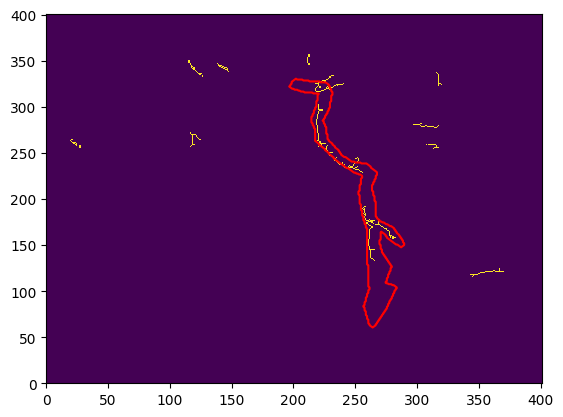

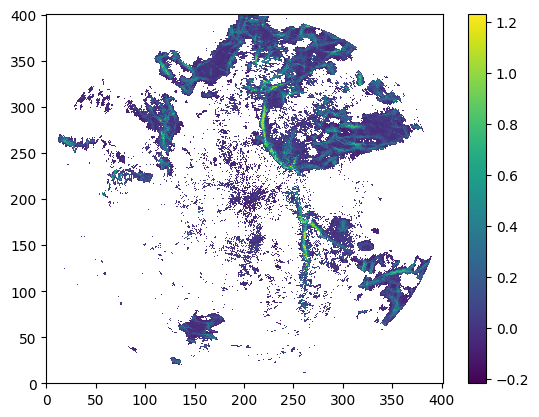

In [16]:
# plt.pcolormesh(remove_small_objects(data['outputGST']>0.4, min_size=10, connectivity=2))
plt.pcolormesh(post_proc(data['outputGST']>0.4))
plt.contour(binary_dilation(data['evalbox'], disk(2)),colors='r')
plt.figure()
plt.pcolormesh(data['outputGST'])
plt.colorbar()

In [115]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
rmap = cm.Reds
bmap = cm.Blues
# Generate example data
x = np.linspace(0, 10, 100)
num_lines = 10
y_values = [np.sin(x + i) for i in range(num_lines)]

# Get a colormap
cmap = cm.viridis
# Normalize color range
norm = mcolors.Normalize(vmin=0, vmax=num_lines - 1)

def case_proc(case_name):
    exp_preds_event = export_preds_dir + case_name
    savedir = os.path.join(fig_dir, case_name)
    os.makedirs(savedir,exist_ok=True)
    npz_list = glob.glob(exp_preds_event + "/*npz")
    hits = []
    miss = []
    false_alarm = []
    total_nf_points = []
    tvec=[]
    for ppi_file in npz_list:
    # for ppi_file in npz_list[:3]:
        print(ppi_file)
        ppi_id = os.path.basename(ppi_file)
        data = np.load(ppi_file)
        Cx = data['xi2']
        Cy = data['yi2']
        # REF = data['REF']
        REF = data['inputNF'][:,:,1]
        evalbox = data['evalbox']
        r = np.sqrt(Cx**2+Cy**2)
        mask = r>=100
        evalline = skeletonize(data['evalbox'])
        ppi_name = ppi_id[11:]  # MATLAB 12:end is Python 11: (0-based)
        date_part = ppi_name[4:12]   # 5:12 in MATLAB → 4:12 in Python
        time_part = ppi_name[13:19]  # 14:19 in MATLAB → 13:19 in Python
        vsch = []; vscm = []; vscf = []; vscp = []
        for thv in np.arange(0.1,0.91,0.1):
            sch,scm,scf,scp = eval_nf(post_proc(data['outputGST']>thv),evalline,evalbox)
            vsch.append(sch)
            vscm.append(scm)
            vscf.append(scf)
            vscp.append(scp)
        
        hits.append(vsch)
        miss.append(vscm)
        false_alarm.append(vscf)
        total_nf_points.append(vscp)
        
        
        # # Parse date and time
        tstamp_date = datetime.strptime(date_part, "%Y%m%d")
        tstamp_time = datetime.strptime(time_part, "%H%M%S").time()
        tstamp = datetime.combine(tstamp_date.date(), tstamp_time)
        tvec.append(tstamp)

    hits = np.array(hits)
    miss = np.array(miss)
    false_alarm = np.array(false_alarm)
    total_nf_points = np.array(total_nf_points)
    HR = 1e2*hits/(miss+hits)
    FAR = 1e2*false_alarm/(total_nf_points)
    for ic in range(9):
        # plt.plot(tvec,HR[:,ic], marker='o',color=rmap(0.4+ic*0.05),label=f'Mean PLD = {np.nanmean(hits/(miss+hits))*100:.2f}%')
        # plt.plot(tvec,FAR[:,ic], marker='o',color=bmap(0.4+ic*0.05),label=f'Mean PFD = {np.nanmean(false_alarm/(total_nf_points))*100:.2f}%')
        plt.plot(tvec,HR[:,ic], marker='o',color=rmap(0.4+ic*0.05),label=f'PLD')
        plt.plot(tvec,FAR[:,ic], marker='o',color=bmap(0.4+ic*0.05),label=f'PFD')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.title(case_name)
    # plt.xlabel('Time (Frame)')
    plt.ylabel('Percentage (%)')
    lines = plt.gca().get_lines()
    plt.legend(handles=lines[-2:], loc='lower right',
    bbox_to_anchor=(1, 1.02),  # (x=1 means right end of axes, y=just above)
    borderaxespad=0,
    frameon=True)
    plt.tight_layout()
    plt.savefig(os.path.join(savedir, 'far_sen.png'))
    plt.close()

    plt.subplots(1, 1, figsize=(8, 5),dpi=250)
    for ic in range(9):
        plt.plot(FAR[:,ic],HR[:,ic],'o',label=f'thr = {0.1+0.1*ic:.1f} PLD = {np.nanmean(HR[:,ic]):.1f}% PFD = {np.nanmean(FAR[:,ic]):.1f}%')
    plt.plot([0, 100], [0, 100], 'k--', label='No Skill')
    plt.title(case_name)
    plt.xlabel('PFD (%)')
    plt.ylabel('PLD (%)')
    # plt.legend()
    
    plt.axis('equal')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.savefig(os.path.join(savedir, savedir.split('/')[-1]+'ROC.png'))
    plt.close()


In [116]:
# case_proc(clist[0])
# plt.figure()
# case_proc(clist[1])
for case_name in clist[0:5:2]:
    print(case_name)
    case_proc(case_name)

KABX20200704_02
./tracking_points/nf_preds/KABX20200704_02/nf_pred_02_KABX20200704_022322_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_03_KABX20200704_022945_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_04_KABX20200704_023622_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_05_KABX20200704_024300_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_06_KABX20200704_024922_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_07_KABX20200704_025724_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_08_KABX20200704_030346_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_09_KABX20200704_031036_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_10_KABX20200704_031714_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_11_KABX20200704_032421_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_12_KABX20200704_033128_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_13_KABX20200704_033835_V06.npz


/tmp/ipykernel_70228/2452490581.py:98: RuntimeWarning: invalid value encountered in divide
  FAR = 1e2*false_alarm/(total_nf_points)


KABX20200715_23
./tracking_points/nf_preds/KABX20200715_23/nf_pred_02_KABX20200715_232706_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_03_KABX20200715_233358_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_04_KABX20200715_234056_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_05_KABX20200715_234804_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_06_KABX20200715_235512_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_07_KABX20200716_000152_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_08_KABX20200716_000833_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_09_KABX20200716_001513_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_10_KABX20200716_002154_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_11_KABX20200716_002833_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_12_KABX20200716_003513_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_13_KABX20200716_004154_V06.npz


/tmp/ipykernel_70228/2452490581.py:121: RuntimeWarning: Mean of empty slice
  plt.plot(FAR[:,ic],HR[:,ic],'o',label=f'thr = {0.1+0.1*ic:.1f} PLD = {np.nanmean(HR[:,ic]):.1f}% PFD = {np.nanmean(FAR[:,ic]):.1f}%')


In [64]:
case_name = clist[0]
exp_preds_event = export_preds_dir + case_name
savedir = os.path.join(fig_dir, case_name)
os.makedirs(savedir,exist_ok=True)
npz_list = glob.glob(exp_preds_event + "/*npz")
hits = []
miss = []
false_alarm = []
total_nf_points = []
tvec=[]
npz_list

In [102]:
from tminlib import plot_helper as phelp
from matplotlib.colors import ListedColormap

case_name = clist[0]
exp_preds_event = export_preds_dir + case_name
savedir = os.path.join(fig_dir, case_name)
os.makedirs(savedir,exist_ok=True)
npz_list = glob.glob(exp_preds_event + "/*npz")
hits = []
miss = []
false_alarm = []
total_nf_points = []
tvec=[]
ppi_file = npz_list[11]
# for ppi_file in npz_list:
# for ppi_file in npz_list[:3]:
print(ppi_file)
ppi_id = os.path.basename(ppi_file)
data = np.load(ppi_file)
Cx = data['xi2']
Cy = data['yi2']
# REF = data['REF']
REF = data['inputNF'][:,:,1]
evalbox = data['evalbox']
r = np.sqrt(Cx**2+Cy**2)
mask = r>=100
evalline = skeletonize(data['evalbox'])
ppi_name = ppi_id[11:]  # MATLAB 12:end is Python 11: (0-based)
date_part = ppi_name[4:12]   # 5:12 in MATLAB → 4:12 in Python
time_part = ppi_name[13:19]  # 14:19 in MATLAB → 13:19 in Python
# vsch = []; vscm = []; vscf = []; vscp = []
# for thv in np.arange(0.1,0.91,0.1):
#     sch,scm,scf,scp = eval_nf(post_proc(data['outputGST']>thv),evalline,evalbox)
#     vsch.append(sch)
#     vscm.append(scm)
#     vscf.append(scf)
#     vscp.append(scp)

thv = 0.6
inGST = data['outputGST']>thv
hGST = medfilt2d(inGST.astype(float), kernel_size=3)
binary_mask = post_moving_avg(hGST) >= 0.6  # Thresholding
pskel_nfout = binary_dilation(binary_mask, disk(5))
skel_nfout = skeletonize(pskel_nfout*inGST)
skel_nfout2 = remove_small_objects(skel_nfout, min_size=10, connectivity=2)



# nfout = data['nfout']
# nfloc = np.logical_and(~mask,nfout)
# nfpredict = dilation(nfloc, disk(5))
# Mhits = np.logical_and(evalline,nfpredict)
# Mmiss = np.logical_and(evalline,~nfpredict)
# # nfloc = skeletonize(nfpredict)

# hits.append(vsch)
# miss.append(vscm)
# false_alarm.append(vscf)
# total_nf_points.append(vscp)


# # Parse date and time
tstamp_date = datetime.strptime(date_part, "%Y%m%d")
tstamp_time = datetime.strptime(time_part, "%H%M%S").time()
tstamp = datetime.combine(tstamp_date.date(), tstamp_time)
tvec.append(tstamp)
# # Extract radar ID
radar_id = ppi_name[0:4]  # 1:4 in MATLAB → 0:4 in Python

# Format description string
ppi_desc = f"{radar_id}, {tstamp.strftime('%m/%d/%Y, %H:%M:%S %Z')}"
fig, axs = plt.subplots(1, 1, figsize=(3/0.7, 2.5/0.7),dpi=250, gridspec_kw=dict(left=0.08, right=1-0.085, top=1-0.08, bottom=0.06, wspace=0.25, hspace=0.16))
# pdata = np.ma.masked_where(mask,REF)
pdata = data['outputGST']
# pdata = skel_nfout2
plt.pcolormesh(Cx,Cy,pdata,cmap='jet',zorder=0)

plt.contour(Cx,Cy,evalbox,[0.5], colors='k',linewidths=0.8,zorder=1)
# plt.text(0.025, 0.975,  f'PLD = {100*hits[-1]/(hits[-1]+miss[-1]):.2f}%\nPLF = {100*false_alarm[-1]/np.sum(nfloc):.2f}%', 
#          transform=plt.gca().transAxes, verticalalignment='top', fontsize=7)
plt.title('Fuzzy Logic Outputs')
plt.axis('equal')
cbar = phelp.add_cbar(axs.collections[0],fig,axs,size='3%')
fig.savefig(os.path.join(savedir, ppi_id[:-4]+'-fuzzy.png'))
plt.close(fig)

fig, axs = plt.subplots(1, 1, figsize=(3/0.7, 2.5/0.7),dpi=250, gridspec_kw=dict(left=0.08, right=1-0.085, top=1-0.08, bottom=0.06, wspace=0.25, hspace=0.16))
pdata = inGST
plt.pcolormesh(Cx,Cy,pdata,cmap=ListedColormap(['#5E75A7', '#FDE725']),zorder=0)
plt.contour(Cx,Cy,evalbox,[0.5], colors='k',linewidths=0.8,zorder=1)
plt.title(f'Thresholding > {thv:.2f}')
plt.axis('equal')
cbar = phelp.add_cbar(axs.collections[0],fig,axs,size='3%')
cbar.set_ticks([0.25, 0.75])  # This sets the tick positions
cbar.set_ticklabels(['False', 'True'])
fig.savefig(os.path.join(savedir, ppi_id[:-4]+'-thr.png'))
plt.close(fig)

fig, axs = plt.subplots(1, 1, figsize=(3/0.7, 2.5/0.7),dpi=250, gridspec_kw=dict(left=0.08, right=1-0.085, top=1-0.08, bottom=0.06, wspace=0.25, hspace=0.16))
pdata = pskel_nfout*inGST
plt.pcolormesh(Cx,Cy,pdata,cmap=ListedColormap(['#5E75A7', '#FDE725']),zorder=0)
plt.contour(Cx,Cy,evalbox,[0.5], colors='k',linewidths=0.8,zorder=1)
plt.title(f'Thresholding > {thv:.2f}')
plt.axis('equal')
cbar = phelp.add_cbar(axs.collections[0],fig,axs,size='3%')
cbar.set_ticks([0.25, 0.75])  # This sets the tick positions
cbar.set_ticklabels(['False', 'True'])
fig.savefig(os.path.join(savedir, ppi_id[:-4]+'-filter.png'))
plt.close(fig)

fig, axs = plt.subplots(1, 1, figsize=(3/0.7, 2.5/0.7),dpi=250, gridspec_kw=dict(left=0.08, right=1-0.085, top=1-0.08, bottom=0.06, wspace=0.25, hspace=0.16))
pdata = skel_nfout
plt.pcolormesh(Cx,Cy,pdata,cmap=ListedColormap(['#5E75A7', '#FDE725']),zorder=0)
plt.contour(Cx,Cy,evalbox,[0.5], colors='k',linewidths=0.8,zorder=1)
plt.title(f'Thresholding > {thv:.2f}')
plt.axis('equal')
cbar = phelp.add_cbar(axs.collections[0],fig,axs,size='3%')
cbar.set_ticks([0.25, 0.75])  # This sets the tick positions
cbar.set_ticklabels(['False', 'True'])
fig.savefig(os.path.join(savedir, ppi_id[:-4]+'-skeleton.png'))
plt.close(fig)

fig, axs = plt.subplots(1, 1, figsize=(3/0.7, 2.5/0.7),dpi=250, gridspec_kw=dict(left=0.08, right=1-0.085, top=1-0.08, bottom=0.06, wspace=0.25, hspace=0.16))
pdata = skel_nfout2
plt.pcolormesh(Cx,Cy,pdata,cmap=ListedColormap(['#5E75A7', '#FDE725']),zorder=0)
plt.contour(Cx,Cy,evalbox,[0.5], colors='k',linewidths=0.8,zorder=1)
plt.title(f'Thresholding > {thv:.2f}')
plt.axis('equal')
cbar = phelp.add_cbar(axs.collections[0],fig,axs,size='3%')
cbar.set_ticks([0.25, 0.75])  # This sets the tick positions
cbar.set_ticklabels(['False', 'True'])
fig.savefig(os.path.join(savedir, ppi_id[:-4]+'-nf.png'))
plt.close(fig)


./tracking_points/nf_preds/KABX20200704_02/nf_pred_13_KABX20200704_033835_V06.npz


In [5]:
case_name = clist[0]
exp_preds_event = export_preds_dir + case_name
# savedir = os.path.join(fig_dir, case_name)
# os.makedirs(savedir,exist_ok=True)
npz_list = glob.glob(exp_preds_event + "/*npz")
ppi_file = npz_list[1]
print(ppi_file)
data = np.load(ppi_file)
data.files

./tracking_points/nf_preds/KABX20200704_02/nf_pred_03_KABX20200704_022945_V06.npz


['xi2', 'yi2', 'REF', 'nfout', 'inputNF', 'evalbox', 'outputGST']

In [3]:
from scipy.spatial import cKDTree
from matplotlib import cm

# gfv = [4, 32]
class GFSpace:
    def __init__(self, gfv = [18, 72]):
        self.gfv = gfv
        self.data =[]
        self.nf_pair = []
        self.nf_loc = []
        self.tstamp = []
    
    def load_nf(self,fn):
        self.data.append(np.load(fn))
        self.tstamp.append(get_tstamp(fn))
        self.nf_loc.append( {'x':self.data[-1]['xi2'][self.data[-1]['nfout']],'y':self.data[-1]['yi2'][self.data[-1]['nfout']],
                             'idx':np.arange(self.data[-1]['xi2'].size).reshape(self.data[-1]['xi2'].shape)[self.data[-1]['nfout']]})
        if len(self.nf_loc)>1:
            self.nf_pair.append(self.connect_nf(self.nf_loc[-2],self.nf_loc[-1],(self.tstamp[-1]-self.tstamp[-2]).total_seconds()))
        else:
            self.shp = self.data[0]['xi2'].shape
            
    def connect_nf(self,t1,t2,dt):
        A = np.column_stack((t1['x'].reshape(-1), t1['y'].reshape(-1)))
        B = np.column_stack((t2['x'].reshape(-1), t2['y'].reshape(-1)))
        # coord [dim_sample, dim_xy]
        # coord [dim_sample, 2]
        tree = cKDTree(A)
        dists_for, indices_for = tree.query(B)
        tree = cKDTree(B)
        dists_bac, indices_bac = tree.query(A)
        pair_pool = np.vstack((np.column_stack((indices_for,np.arange(B.shape[0]))),np.column_stack((np.arange(A.shape[0]),indices_bac)))).astype(int)
        dists_pool = np.concatenate((dists_for,dists_bac),axis=0)
        mask = np.logical_and(dists_pool > self.gfv[0]*dt/3600, dists_pool < self.gfv[1]*dt/3600)
        return np.concatenate((pair_pool[mask,:],np.zeros(np.sum(mask),dtype=bool).reshape(-1,1)),axis=1)
        
        # return pair_pool[mask,:].astype(int)
    def clean_short_track(self):
        for ic in range(len(self.nf_pair)-1):
            keep_mask = np.logical_or(np.isin(self.nf_pair[ic][:,1], np.unique(self.nf_pair[ic+1][:,0])),self.nf_pair[ic][:,2]>0)
            self.nf_pair[ic] = self.nf_pair[ic][keep_mask,:]
            self.nf_pair[ic+1][:,2] = np.logical_or(self.nf_pair[ic+1][:,2], np.isin(self.nf_pair[ic+1][:, 0], self.nf_pair[ic][:, 1]))
    
    def clean_random_track_motion(self):
        self.cal_motion()
        for ic in range(len(self.nf_pair)-1):
            curdir = self.nf_pair[ic][:,-2]+1j*self.nf_pair[ic][:,-1]
            nextdir = np.zeros(curdir.size)
            for ip in range(curdir.size):
                mask = self.nf_pair[ic+1][:,0]==self.nf_pair[ic][ip,1]
                nextdir[ip] = np.mean(self.nf_pair[ic+1][mask,-2]+1j*self.nf_pair[ic+1][mask,-1],axis=0)
            dirdiff = get_dirdiff(curdir,nextdir)
            self.nf_pair[ic]=np.concatenate((self.nf_pair[ic],dirdiff.reshape(-1,1)),axis=1)
        
    def cal_motion(self):
        for ic in range(len(self.nf_pair)):
            t1 = self.nf_loc[ic]
            t2 = self.nf_loc[ic+1]
            A = np.column_stack((t1['x'].reshape(-1), t1['y'].reshape(-1)))
            B = np.column_stack((t2['x'].reshape(-1), t2['y'].reshape(-1)))
            start = A[self.nf_pair[ic][:,0]]
            end = B[self.nf_pair[ic][:,1]]
            motion = end-start
            self.nf_pair[ic]=np.concatenate((self.nf_pair[ic],motion),axis=1)
    
    def get_cln_nf(self,ic):
        buf = np.zeros(self.shp,dtype=bool).reshape(-1)
        buf[self.nf_loc[ic]['idx'][self.nf_pair[ic][:,0].astype(int)]]=True
        return buf.reshape(self.shp)

def get_tstamp(ppi_file):
    ppi_id = os.path.basename(ppi_file)
    ppi_name = ppi_id[11:]
    date_part = ppi_name[4:12]   # 5:12 in MATLAB → 4:12 in Python
    time_part = ppi_name[13:19]  # 14:19 in MATLAB → 13:19 in Python
    tstamp_date = datetime.strptime(date_part, "%Y%m%d")
    tstamp_time = datetime.strptime(time_part, "%H%M%S").time()
    tstamp = datetime.combine(tstamp_date.date(), tstamp_time)
    return tstamp

def get_dirdiff(dir1,dir2):
    return np.rad2deg(np.angle(dir1*np.conj(dir2)))


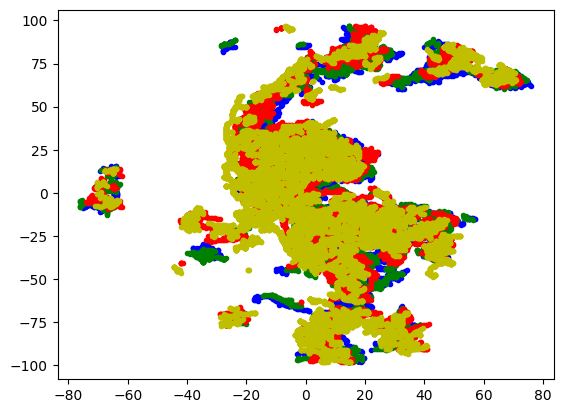

In [169]:
wgfspace = GFSpace( gfv = [4, 32])
for i in range(10,15):
    wgfspace.load_nf(npz_list[i])
wgfspace.clean_short_track()
for i,clmt in enumerate(['b.','g.','r.','y.']):
    plt.plot(wgfspace.nf_loc[i]['x'][wgfspace.nf_pair[i][:,0]],wgfspace.nf_loc[i]['y'][wgfspace.nf_pair[i][:,0]],clmt)

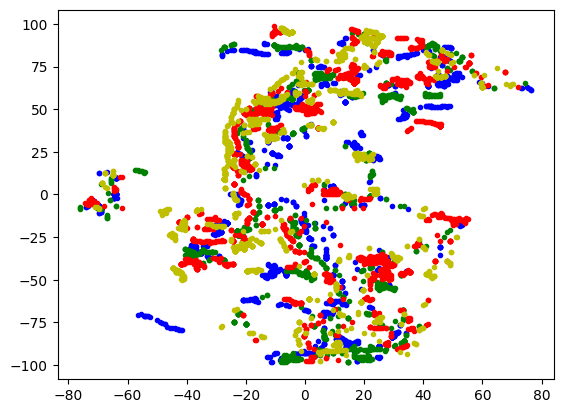

In [160]:
wgfspace = GFSpace()
for i in range(10,15):
    wgfspace.load_nf(npz_list[i])
for i,clmt in enumerate(['b.','g.','r.','y.']):
    plt.plot(wgfspace.nf_loc[i]['x'][wgfspace.nf_pair[i][:,0]],wgfspace.nf_loc[i]['y'][wgfspace.nf_pair[i][:,0]],clmt)

In [187]:
case_name = clist[4]
exp_preds_event = export_preds_dir + case_name
# savedir = os.path.join(fig_dir, case_name)
# os.makedirs(savedir,exist_ok=True)
npz_list = glob.glob(exp_preds_event + "/*npz")

/tmp/ipykernel_4236/927875041.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jets = cm.get_cmap('jet', len(npz_list))


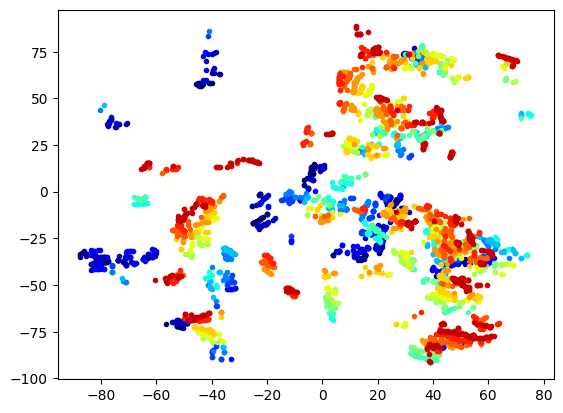

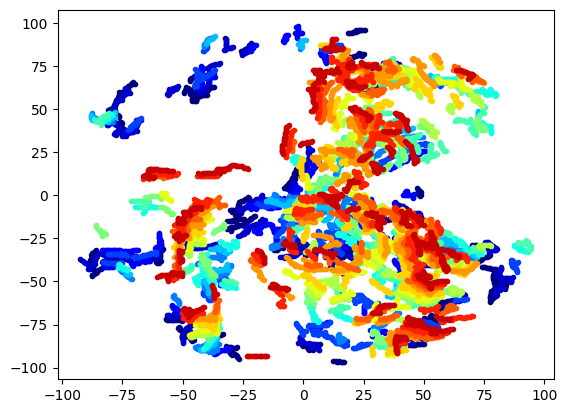

In [188]:
wgfspace = GFSpace(gfv = [18, 32])
for ifn in npz_list:
    wgfspace.load_nf(ifn)
wgfspace.clean_short_track()
# N = 5

jets = cm.get_cmap('jet', len(npz_list)) 
for i,clmt in enumerate([jets(ic) for ic in range(len(npz_list)-1)]):
    plt.plot(wgfspace.nf_loc[i]['x'][wgfspace.nf_pair[i][:,0]],wgfspace.nf_loc[i]['y'][wgfspace.nf_pair[i][:,0]],color=clmt,marker='.',linestyle='')
plt.figure()
for i,clmt in enumerate([jets(ic) for ic in range(len(npz_list)-1)]):
    plt.plot(wgfspace.nf_loc[i]['x'],wgfspace.nf_loc[i]['y'],color=clmt,marker='.',linestyle='')

/tmp/ipykernel_871/3033765125.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  nextdir[ip] = np.mean(self.nf_pair[ic+1][mask,-2]+1j*self.nf_pair[ic+1][mask,-1],axis=0)


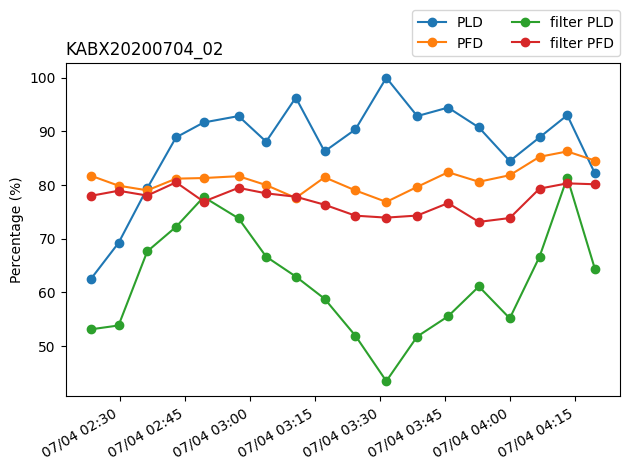

In [147]:
wgfspace = case_proc(clist[0])

/tmp/ipykernel_871/2544494649.py:47: RuntimeWarning: invalid value encountered in scalar divide
  HR = 1e2*Mhits/np.sum(nfeval)


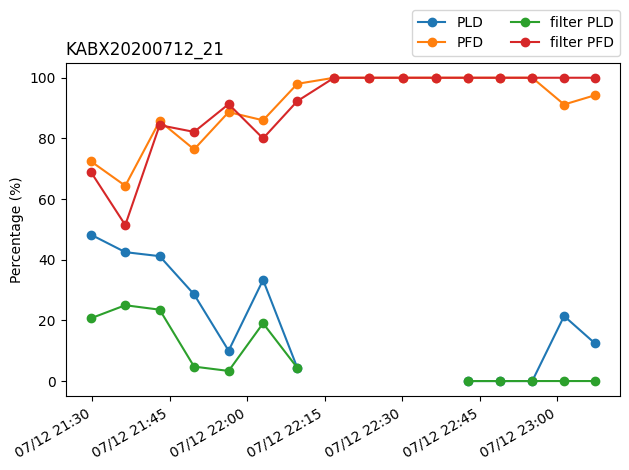

In [79]:
wgfspace = case_proc(clist[3])

/tmp/ipykernel_871/2544494649.py:47: RuntimeWarning: invalid value encountered in scalar divide
  HR = 1e2*Mhits/np.sum(nfeval)


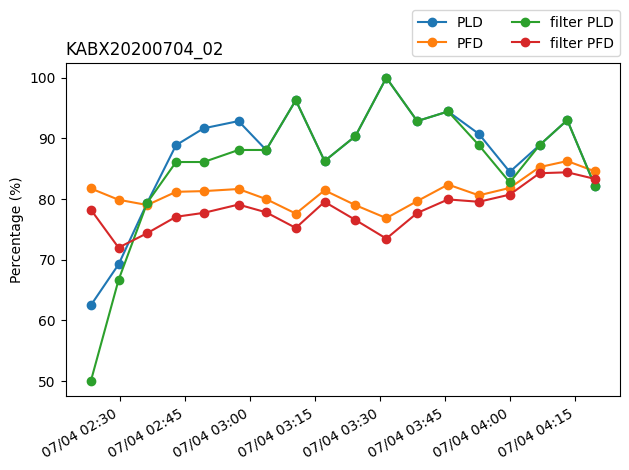

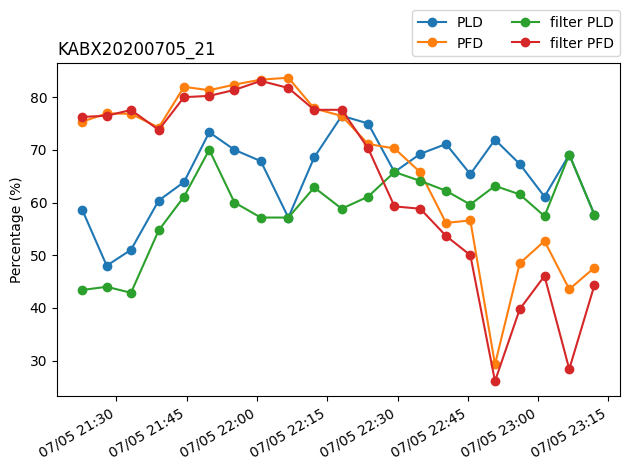

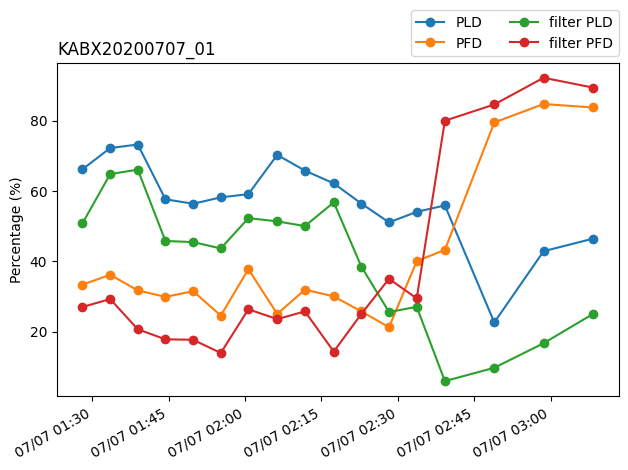

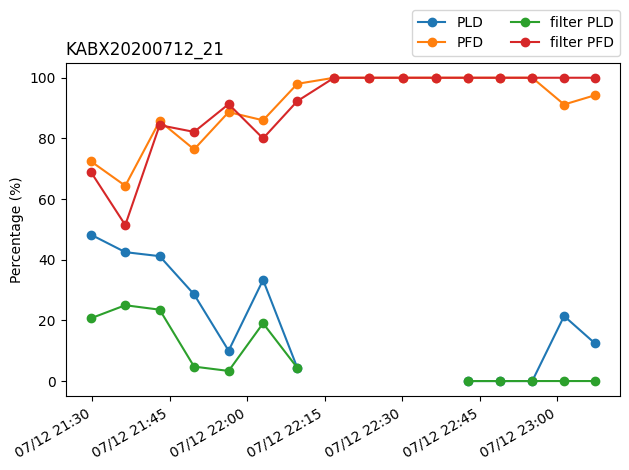

<Figure size 640x480 with 0 Axes>

In [19]:
for ic in range(4):
    wgfspace = case_proc(clist[ic])
    plt.figure()

In [16]:
def case_proc(case_name,plot_on=False):
    exp_preds_event = export_preds_dir + case_name
    savedir = os.path.join(fig_dir, case_name)
    os.makedirs(savedir,exist_ok=True)
    npz_list = glob.glob(exp_preds_event + "/*npz")
    wgfspace = GFSpace([18,72])
    for ppi_file in npz_list:
        wgfspace.load_nf(ppi_file)
    # wgfspace.clean_short_track()
    # wgfspace.clean_random_track_motion()
    Cx = wgfspace.data[0]['xi2']
    Cy = wgfspace.data[0]['yi2']
    r = np.sqrt(Cx**2+Cy**2)
    mask = r>=100
    
    tvec = wgfspace.tstamp[:-1]
    hr_pre = []
    hr_pos = []
    fa_pre = []
    fa_pos = []
    for ic,data in enumerate(wgfspace.data[:-1]):
        evalbox = data['evalbox']
        evalline = skeletonize(data['evalbox'])
        hr,fa = eval_nf(data['nfout'],evalline,evalbox,~mask)
        hr_pre.append(hr)
        fa_pre.append(fa)

        proc_nf = wgfspace.get_cln_nf(ic)
        hr,fa = eval_nf(proc_nf,evalline,evalbox,~mask)
        hr_pos.append(hr)
        fa_pos.append(fa)
        
        ppi_file = npz_list[ic]
        print(ppi_file)
        ppi_id = os.path.basename(ppi_file)
        ppi_name = ppi_id[11:]  # MATLAB 12:end is Python 11: (0-based)
        date_part = ppi_name[4:12]   # 5:12 in MATLAB → 4:12 in Python
        time_part = ppi_name[13:19]
    
        radar_id = ppi_name[0:4]  # 1:4 in MATLAB → 0:4 in Python
        tstamp_date = datetime.strptime(date_part, "%Y%m%d")
        tstamp_time = datetime.strptime(time_part, "%H%M%S").time()
        tstamp = datetime.combine(tstamp_date.date(), tstamp_time)
        ppi_desc = f"{radar_id}, {tstamp.strftime('%m/%d/%Y, %H:%M:%S %Z')}"
    
    
        fig, axs = plt.subplots(1, 2, figsize=(7/0.7, 2.5/0.7),dpi=250, gridspec_kw=dict(left=0.08, right=1-0.085, top=1-0.08, bottom=0.06, wspace=0.25, hspace=0.16))
        REF = data['inputNF'][:,:,1]
        pdata = np.ma.masked_where(mask,REF)

        def plot_nf(ax,nfout,hrt,fat):
            evalbox = data['evalbox']
            nfloc = np.logical_and(~mask,nfout)
            nfpredict = dilation(nfloc, disk(5))
            Mhits = np.logical_and(evalline,nfpredict)
            Mmiss = np.logical_and(evalline,~nfpredict)
            ax.pcolormesh(Cx,Cy,pdata,cmap=cl.zmap,norm=cl.znorm)
            ax.plot(Cx[nfloc],Cy[nfloc],'k.',markersize=0.8)
            ax.plot(Cx[np.logical_and(nfloc,evalbox)],Cy[np.logical_and(nfloc,evalbox)],'r.',markersize=0.8)
            ax.plot(Cx[evalline],Cy[evalline],'b.',markersize=0.8)
            ax.plot(Cx[Mhits],Cy[Mhits],'.',color=(0,1,0),markersize=0.8)
            ax.contour(Cx,Cy,evalbox,[0.5], colors='y',linewidths=0.8)
            ax.text(0.025, 0.975,  f'PLD = {hrt:.2f}%\nPLP = {fat:.2f}%', 
                     transform=ax.transAxes, verticalalignment='top', fontsize=7)
            # ax.text(0.025, 0.975,  f'PLD = {hrt:.2f}%\nPFD = {fat:.2f}%', 
            #          transform=ax.transAxes, verticalalignment='top', fontsize=7)
            ax.set_title(ppi_desc)
            ax.axis('equal')
            phelp.add_cbar(ax.collections[0],fig,ax,unit_text = varunit_table['Zh'],size='3%')
        plot_nf(axs[0],data['nfout'],hr_pre[-1],100-fa_pre[-1])
        plot_nf(axs[1],proc_nf,hr_pos[-1],100-fa_pos[-1])
        # plot_nf(axs[0],data['nfout'],hr_pre[-1],fa_pre[-1])
        # plot_nf(axs[1],proc_nf,hr_pos[-1],fa_pos[-1])
        fig.savefig(os.path.join(savedir, ppi_id[:-4]+'.png'))
        plt.close(fig)    

    
    plt.plot(tvec,hr_pre, marker='o',label=f'PLD')
    plt.plot(tvec,100-np.array(fa_pre), marker='o',label=f'PLP')
    plt.plot(tvec,hr_pos, marker='o',label=f'filter PLD')
    plt.plot(tvec,100-np.array(fa_pos), marker='o',label=f'filter PLP')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.title(case_name,loc='left')
    # plt.xlabel('Time (Frame)')
    plt.ylabel('Percentage (%)')
    # lines = plt.gca().get_lines()
    plt.legend(ncol=2,loc='lower right',
    bbox_to_anchor=(1, 1.02),  # (x=1 means right end of axes, y=just above)
    borderaxespad=0,
    frameon=True)
    plt.tight_layout()
    plt.savefig(os.path.join(savedir, 'far_com.png'))
    return wgfspace

./tracking_points/nf_preds/KABX20200704_02/nf_pred_02_KABX20200704_022322_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_03_KABX20200704_022945_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_04_KABX20200704_023622_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_05_KABX20200704_024300_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_06_KABX20200704_024922_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_07_KABX20200704_025724_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_08_KABX20200704_030346_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_09_KABX20200704_031036_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_10_KABX20200704_031714_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_11_KABX20200704_032421_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_12_KABX20200704_033128_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_13_KABX20200704_033835_V06.npz
./tracking_point

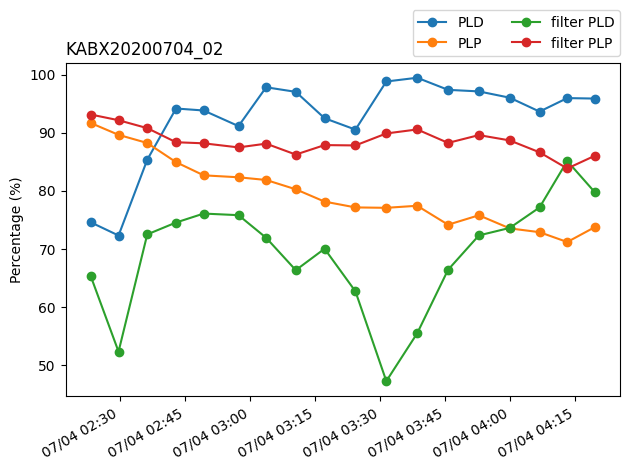

In [17]:
wgfspace = case_proc(clist[0])

In [206]:
for case_name in clist:
    print(case_name)
    fig = plt.figure()
    wgfspace = case_proc(case_name)
    plt.close(fig)

KABX20200704_02
./tracking_points/nf_preds/KABX20200704_02/nf_pred_02_KABX20200704_022322_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_03_KABX20200704_022945_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_04_KABX20200704_023622_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_05_KABX20200704_024300_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_06_KABX20200704_024922_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_07_KABX20200704_025724_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_08_KABX20200704_030346_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_09_KABX20200704_031036_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_10_KABX20200704_031714_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_11_KABX20200704_032421_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_12_KABX20200704_033128_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_13_KABX20200704_033835_V06.npz


/tmp/ipykernel_871/1132037389.py:42: RuntimeWarning: invalid value encountered in scalar divide
  HR = 1e2*sch/(scm+sch)


./tracking_points/nf_preds/KABX20200712_21/nf_pred_09_KABX20200712_221648_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_10_KABX20200712_222333_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_11_KABX20200712_223003_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_12_KABX20200712_223628_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_13_KABX20200712_224244_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_14_KABX20200712_224900_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_15_KABX20200712_225509_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_16_KABX20200712_230119_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_17_KABX20200712_230714_V06.npz
KABX20200715_23
./tracking_points/nf_preds/KABX20200715_23/nf_pred_02_KABX20200715_232706_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_03_KABX20200715_233358_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_04_KABX20200715_234056_V06.npz


(array([30.,  9., 45., 43., 36., 93., 61., 45., 24., 12.]),
 array([  0.        ,  17.42894069,  34.85788137,  52.28682206,
         69.71576275,  87.14470343, 104.57364412, 122.0025848 ,
        139.43152549, 156.86046618, 174.28940686]),
 <BarContainer object of 10 artists>)

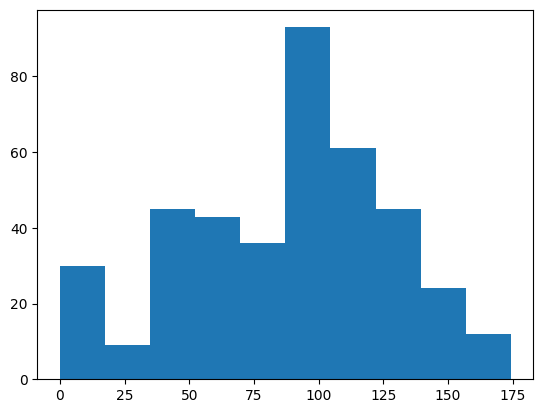

In [152]:
plt.hist(np.abs(wgfspace.nf_pair[ic][:,-1]))

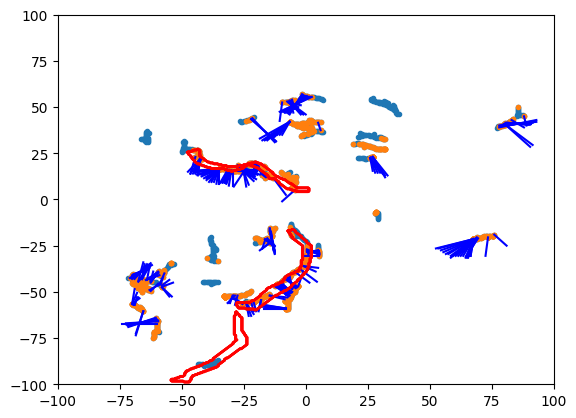

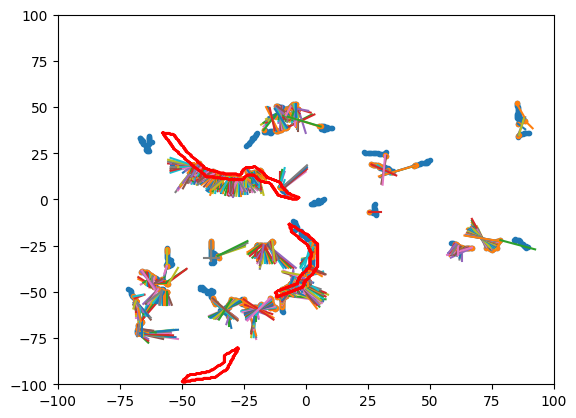

In [157]:
ic = 4
start = wgfspace.nf_pair[ic][:,0].astype(int)
prd = wgfspace.data[ic]['nfout']
plt.plot(wgfspace.data[ic]['xi2'][prd],wgfspace.data[ic]['yi2'][prd],'.')
plt.plot(wgfspace.nf_loc[ic]['x'][start],wgfspace.nf_loc[ic]['y'][start],'.')

vx = np.vstack((wgfspace.nf_loc[ic]['x'][start],wgfspace.nf_loc[ic]['x'][start]+wgfspace.nf_pair[ic][:,-3]*2))
vy = np.vstack((wgfspace.nf_loc[ic]['y'][start],wgfspace.nf_loc[ic]['y'][start]+wgfspace.nf_pair[ic][:,-2]*2))
dirdf = np.abs(wgfspace.nf_pair[ic][:,-1])

plt.plot(vx[:,dirdf<90],vy[:,dirdf<90],'b')
# plt.plot(vx[:,dirdf>45],vy[:,dirdf>45],'r')
plt.contour(wgfspace.data[ic]['xi2'],wgfspace.data[ic]['yi2'],wgfspace.data[ic]['evalbox'],colors='r')
plt.figure()
ic = 5
start = wgfspace.nf_pair[ic][:,0].astype(int)
prd = wgfspace.data[ic]['nfout']
plt.plot(wgfspace.data[ic]['xi2'][prd],wgfspace.data[ic]['yi2'][prd],'.')
plt.plot(wgfspace.nf_loc[ic]['x'][start],wgfspace.nf_loc[ic]['y'][start],'.')

plt.plot(np.vstack((wgfspace.nf_loc[ic]['x'][start],wgfspace.nf_loc[ic]['x'][start]+wgfspace.nf_pair[ic][:,-3]*2)),
         np.vstack((wgfspace.nf_loc[ic]['y'][start],wgfspace.nf_loc[ic]['y'][start]+wgfspace.nf_pair[ic][:,-2]*2)))
plt.contour(wgfspace.data[ic]['xi2'],wgfspace.data[ic]['yi2'],wgfspace.data[ic]['evalbox'],colors='r')

In [36]:
np.nanmin(wgfspace.data[1]['outputGST'])

1.2321189941059971

In [39]:
def flat_floor(ar):
    buf = ar
    buf[np.isnan(ar)]=np.nanmin(ar)
    return buf

/tmp/ipykernel_871/3084813355.py:6: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(wgfspace.data[ic]['evalbox'],color='y')


(0.0, 2000.0)

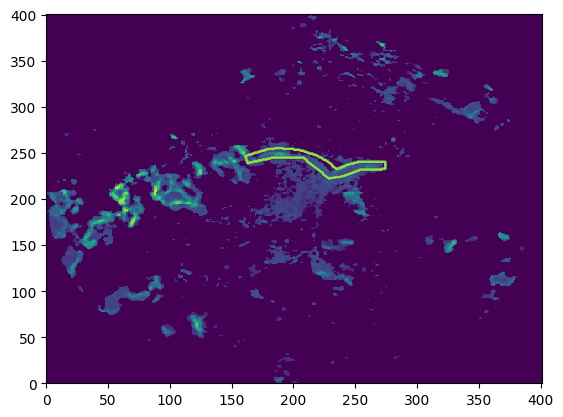

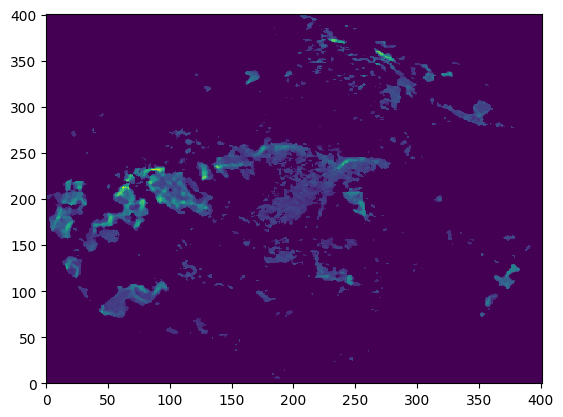

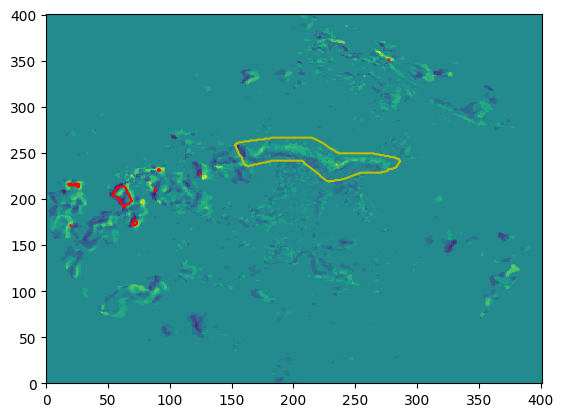

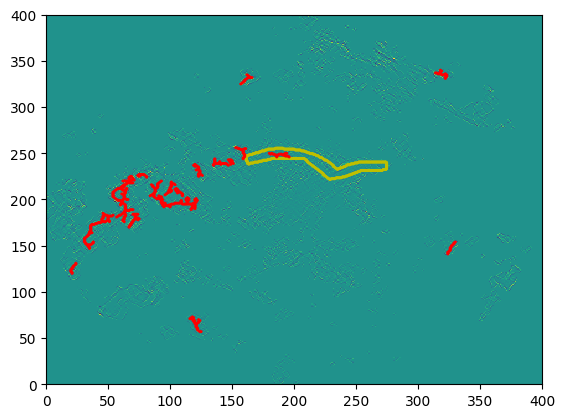

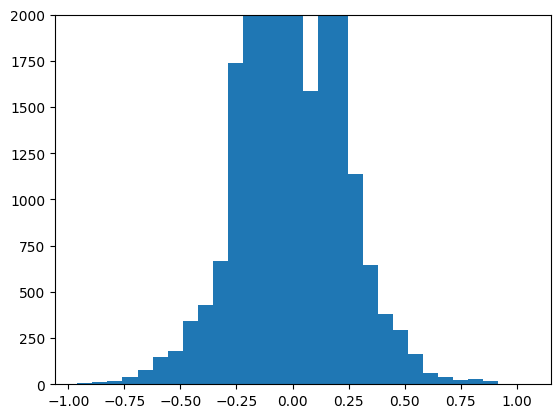

In [88]:
ic = 14
t1 = medfilt2d(flat_floor(wgfspace.data[ic]['outputGST']), kernel_size=3)
t2 = medfilt2d(flat_floor(wgfspace.data[ic+1]['outputGST']), kernel_size=3)

plt.pcolormesh(t1)
plt.contour(wgfspace.data[ic]['evalbox'],color='y')
plt.figure()
plt.pcolormesh(t2)
plt.figure()
dfgst = t2-t1
plt.pcolormesh(dfgst)
# plt.contour(np.logical_or(wgfspace.data[ic]['evalbox'],wgfspace.data[ic+1]['evalbox']),color='y')
plt.contour(dilation(np.logical_or(wgfspace.data[ic]['evalbox'],wgfspace.data[ic+1]['evalbox']),disk(3)),colors='y')
# plt.contour(np.abs(dfgst)>0.48,colors='r')
plt.contour(binary_erosion( binary_dilation(np.abs(dfgst)>0.5,disk(4)),disk(6)),colors='r')
plt.figure()
plt.pcolormesh(np.diff(np.diff(dfgst,axis=0),axis=1))
# plt.contour(np.logical_or(wgfspace.data[ic]['evalbox'],wgfspace.data[ic+1]['evalbox']),color='y')
plt.contour(wgfspace.data[ic]['evalbox'],colors='y')
plt.contour(wgfspace.data[ic]['nfout'],colors='r')

plt.figure()
plt.hist(dfgst.reshape(-1),bins=30)
plt.ylim(0,2000)

/tmp/ipykernel_871/4001133271.py:2: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(wgfspace.data[0]['evalbox'],color='y')
/tmp/ipykernel_871/4001133271.py:8: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(np.logical_or(wgfspace.data[0]['evalbox'],wgfspace.data[1]['evalbox']),color='y')


(0.0, 2000.0)

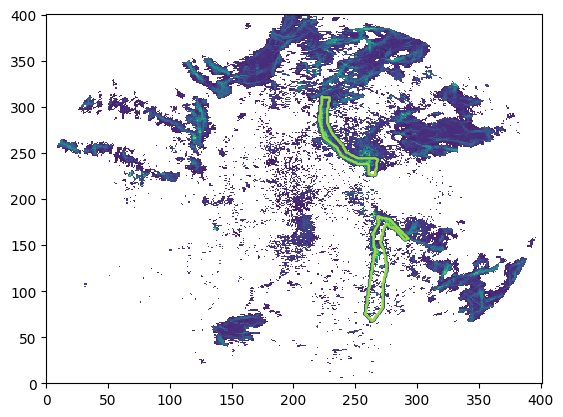

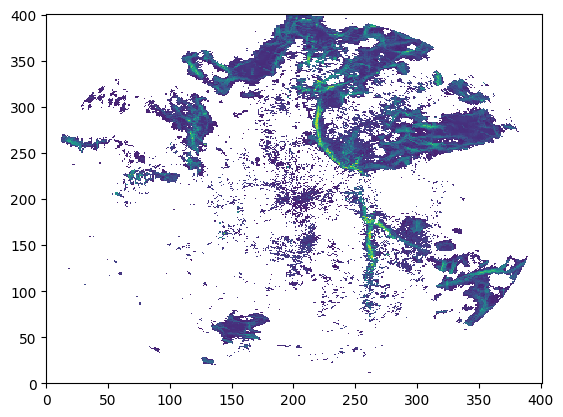

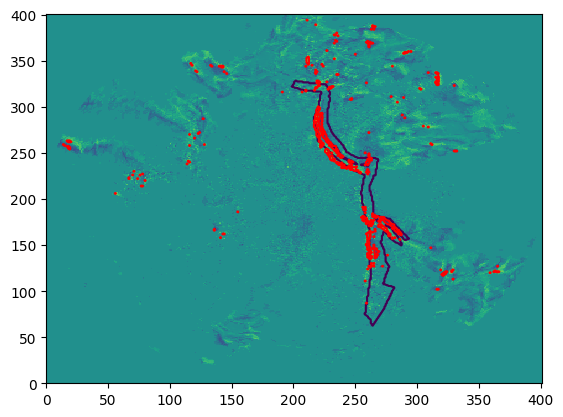

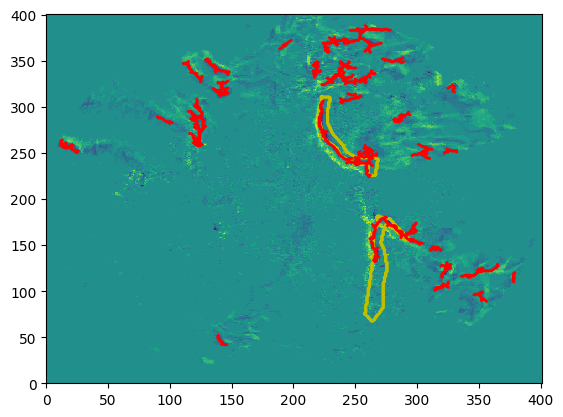

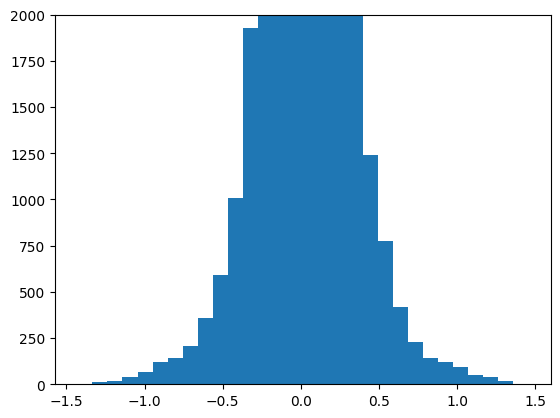

In [56]:
plt.pcolormesh(wgfspace.data[0]['outputGST'])
plt.contour(wgfspace.data[0]['evalbox'],color='y')
plt.figure()
plt.pcolormesh(wgfspace.data[1]['outputGST'])
plt.figure()
dfgst=flat_floor(wgfspace.data[1]['outputGST'])-flat_floor(wgfspace.data[0]['outputGST'])
plt.pcolormesh(dfgst)
plt.contour(np.logical_or(wgfspace.data[0]['evalbox'],wgfspace.data[1]['evalbox']),color='y')
plt.contour(np.abs(dfgst)>0.8,colors='r')
plt.figure()
plt.pcolormesh(dfgst)
# plt.contour(np.logical_or(wgfspace.data[0]['evalbox'],wgfspace.data[1]['evalbox']),color='y')
plt.contour(wgfspace.data[0]['evalbox'],colors='y')
plt.contour(wgfspace.data[0]['nfout'],colors='r')

plt.figure()
plt.hist(dfgst.reshape(-1),bins=30)
plt.ylim(0,2000)


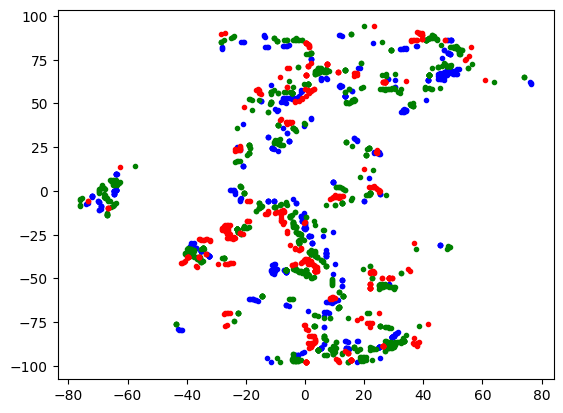

In [97]:
data = []
data.append(np.load(npz_list[10]))
data.append(np.load(npz_list[11]))
nf1 = {'x':data[0]['xi2'][data[0]['nfout']],'y':data[0]['yi2'][data[0]['nfout']]}
nf2 = {'x':data[1]['xi2'][data[1]['nfout']],'y':data[1]['yi2'][data[1]['nfout']]}
buf = connect_nf(nf1,nf2,600)
pairs = np.unique(buf, axis=0)

plt.plot(nf1['x'][pairs[:,0].astype(int)],nf1['y'][pairs[:,0].astype(int)],'b.')
plt.plot(nf2['x'][pairs[:,1].astype(int)],nf2['y'][pairs[:,1].astype(int)],'g.')

data = []
data.append(np.load(npz_list[11]))
data.append(np.load(npz_list[12]))
nf1 = {'x':data[0]['xi2'][data[0]['nfout']],'y':data[0]['yi2'][data[0]['nfout']]}
nf2 = {'x':data[1]['xi2'][data[1]['nfout']],'y':data[1]['yi2'][data[1]['nfout']]}
buf = connect_nf(nf1,nf2,600)
pairs = np.unique(buf, axis=0)

plt.plot(nf1['x'][pairs[:,0].astype(int)],nf1['y'][pairs[:,0].astype(int)],'g.')
plt.plot(nf2['x'][pairs[:,1].astype(int)],nf2['y'][pairs[:,1].astype(int)],'r.')

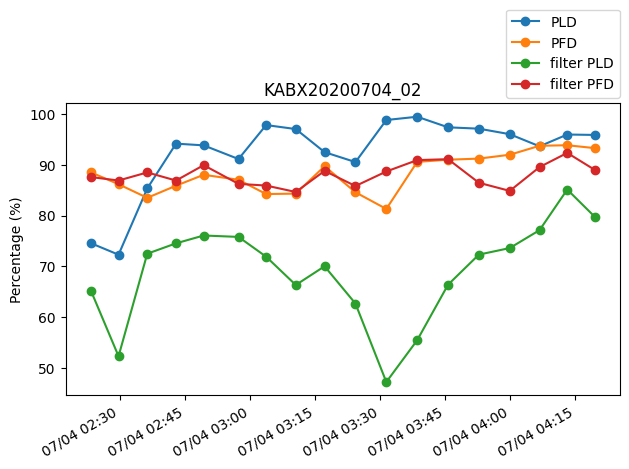

In [221]:
wgfspace = case_proc(clist[0])

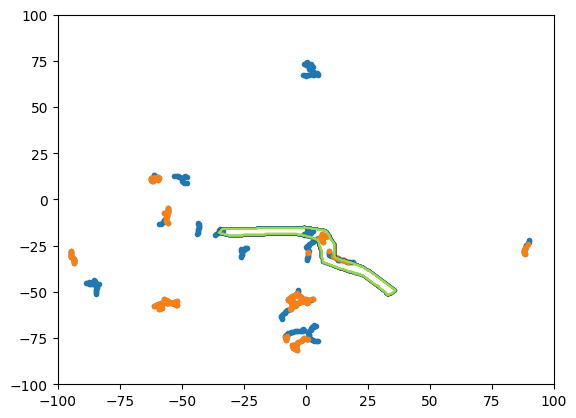

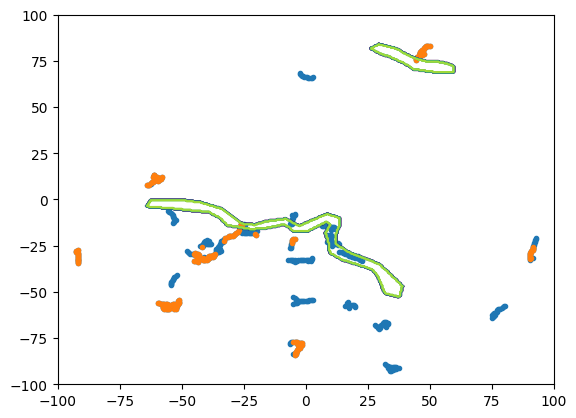

In [21]:
# from scipy.spatial import cKDTree
ic = 2
x = wgfspace.data[ic]['xi2']
y = wgfspace.data[ic]['yi2']
fixnf = wgfspace.get_cln_nf(ic)
plt.plot(x[wgfspace.data[ic]['nfout']],y[wgfspace.data[ic]['nfout']],'.')
plt.plot(x[fixnf],y[fixnf],'.')
plt.contour(x, y,wgfspace.data[ic]['evalbox'])
plt.figure()
ic = 3
x = wgfspace.data[ic]['xi2']
y = wgfspace.data[ic]['yi2']
fixnf = wgfspace.get_cln_nf(ic)
plt.plot(x[wgfspace.data[ic]['nfout']],y[wgfspace.data[ic]['nfout']],'.')
plt.plot(x[fixnf],y[fixnf],'.')
plt.contour(x, y,wgfspace.data[ic]['evalbox'])

# data = []
# data.append(np.load(npz_list[10]))
# A = np.transpose(np.array([data[0]['xi2'][data[0]['nfout']],data[0]['yi2'][data[0]['nfout']]]))
# data.append(np.load(npz_list[11]))
# B = np.transpose(np.array([data[1]['xi2'][data[1]['nfout']],data[1]['yi2'][data[1]['nfout']]]))

# tree = cKDTree(A)
# dists, indices = tree.query(B)
# print(A[indices].shape)
# plt.plot(data[0]['xi2'][data[0]['nfout']],data[0]['yi2'][data[0]['nfout']],'.')
# x=A[indices][:,0]
# y=A[indices][:,1]
# plt.plot(x[np.logical_and(dists>0.4, dists <3.2)],y[np.logical_and(dists>0.4, dists <3.2)],'.')
# plt.contour(data[0]['xi2'],data[0]['yi2'],data[0]['evalbox'])
# plt.figure()
# plt.plot(data[0]['xi2'][data[0]['nfout']],data[0]['yi2'][data[0]['nfout']],'.')


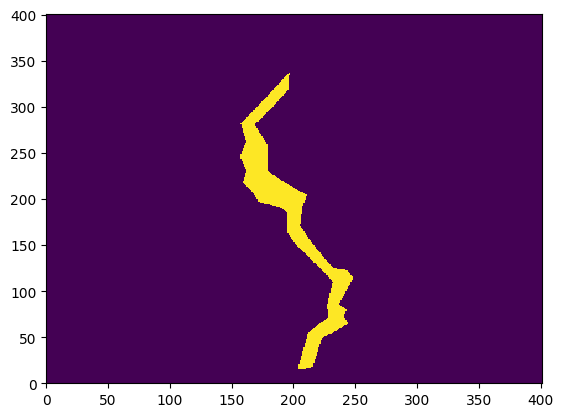

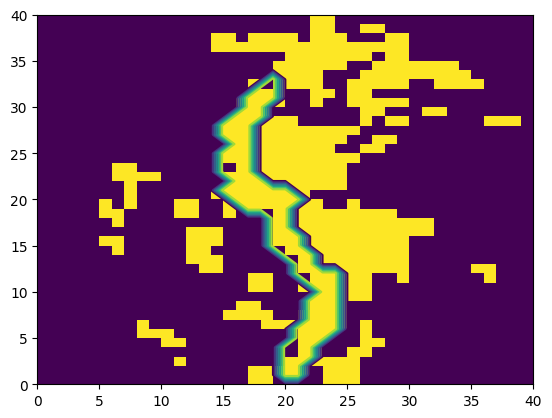

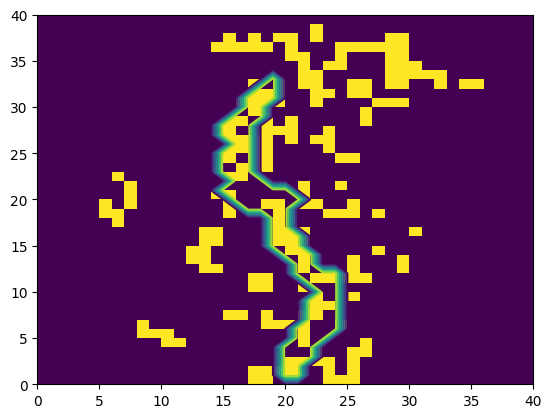

In [230]:
ic=10
plt.pcolormesh(wgfspace.data[ic]['evalbox'])
plt.figure()
plt.pcolormesh(np.max(wgfspace.data[ic]['nfout'][:400,:400].reshape(40,10,40,10),axis=(1,3)))
plt.contour(np.max(wgfspace.data[ic]['evalbox'][:400,:400].reshape(40,10,40,10),axis=(1,3)))
plt.figure()
plt.pcolormesh(np.max(wgfspace.get_cln_nf(ic)[:400,:400].reshape(40,10,40,10),axis=(1,3)))
plt.contour(np.max(wgfspace.data[ic]['evalbox'][:400,:400].reshape(40,10,40,10),axis=(1,3)))

(6853, 2)


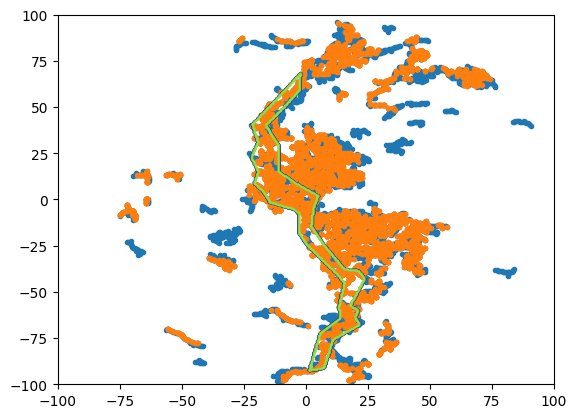

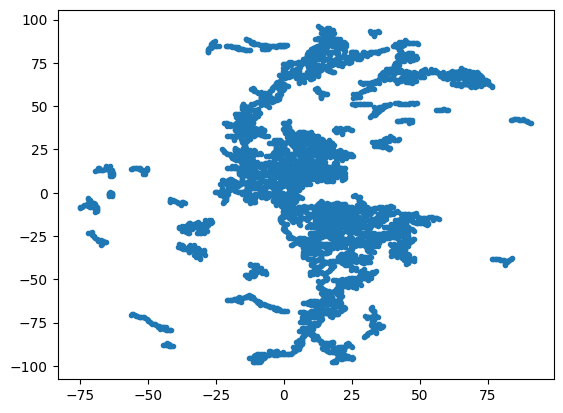

In [6]:
# from scipy.spatial import cKDTree
data = []
data.append(np.load(npz_list[10]))
A = np.transpose(np.array([data[0]['xi2'][data[0]['nfout']],data[0]['yi2'][data[0]['nfout']]]))
data.append(np.load(npz_list[11]))
B = np.transpose(np.array([data[1]['xi2'][data[1]['nfout']],data[1]['yi2'][data[1]['nfout']]]))

tree = cKDTree(A)
dists, indices = tree.query(B)
print(A[indices].shape)
plt.plot(data[0]['xi2'][data[0]['nfout']],data[0]['yi2'][data[0]['nfout']],'.')
x=A[indices][:,0]
y=A[indices][:,1]
plt.plot(x[np.logical_and(dists>0.4, dists <3.2)],y[np.logical_and(dists>0.4, dists <3.2)],'.')
plt.contour(data[0]['xi2'],data[0]['yi2'],data[0]['evalbox'])
plt.figure()
plt.plot(data[0]['xi2'][data[0]['nfout']],data[0]['yi2'][data[0]['nfout']],'.')

In [28]:

print(get_tstamp(npz_list[0]))
print(get_tstamp(npz_list[1]))
print((get_tstamp(npz_list[2])-get_tstamp(npz_list[2])).total_seconds())

2020-07-04 02:23:22
2020-07-04 02:29:45
398.0
